In [103]:
import datacube
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import uuid
from pathlib import Path
import yaml
from hashlib import md5
from osgeo import osr
import glob
from osgeo import gdal

import numpy as np
import pandas as pd
import joblib

ModuleNotFoundError: No module named 'osgeo'

In [2]:

import geopandas as gpd

In [42]:
can = gpd.GeoDataFrame.from_file(r"C:\Users\maxim\Downloads\P1Maps74DPdf\74D\Metadata\Index\Shapefile\Phase1ForestInventoryGeneralized.shp")

In [53]:
can_epsg = can.to_crs("EPSG:4326")

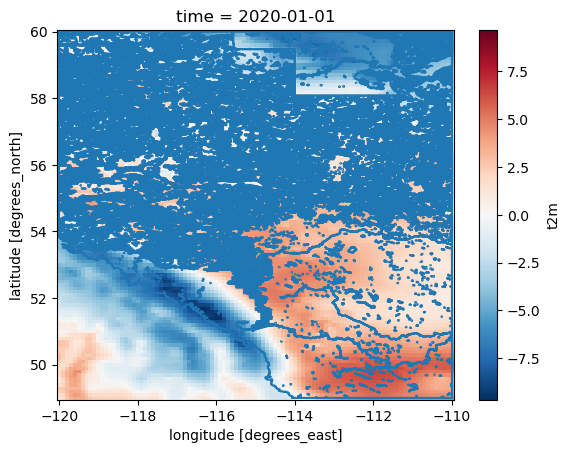

In [22]:

can_epsg.boundary.plot()
(era.isel(time=0)['t2m']-270).plot.imshow()

In [111]:
x, y = alberta.geometry.exterior.xy


In [112]:
era = xr.open_dataset(r'era5\era5.nc')

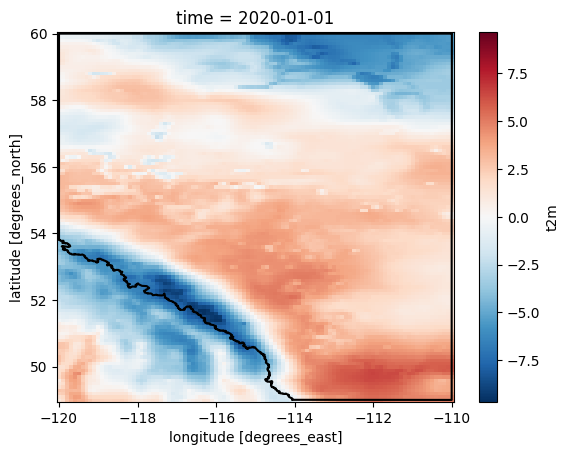

In [116]:
(era.isel(time=0)['t2m']-270).plot.imshow()
plt.plot(x, y, color='black')

In [ ]:
(modis_ndvi_dc['NDVI'].isel(time=0)/10000).plot.imshow(vmin=0)
plt.plot(x, y, color='black')

In [ ]:
(modis_dc['lai'].isel(time=0)/255).plot.imshow(vmin=0)
plt.plot(x, y, color='black')

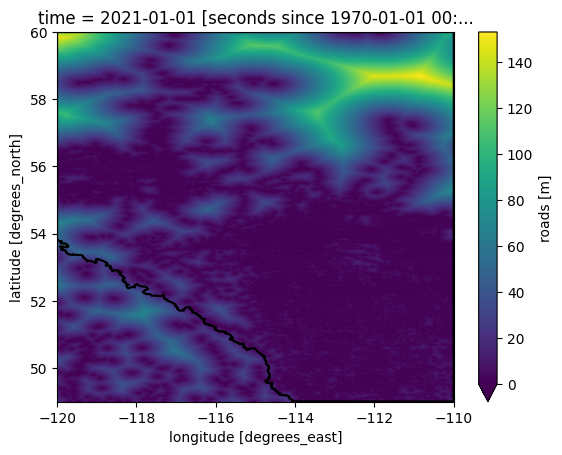

In [145]:
(roads['roads'].isel(time=0)).plot.imshow(vmin=0)
plt.plot(x, y, color='black')

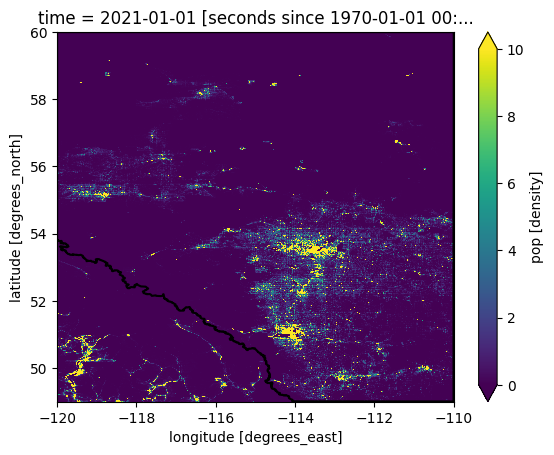

In [151]:
(pop['pop'].isel(time=0)).plot.imshow(vmax=10, vmin=0)
plt.plot(x, y, color='black')

In [99]:
filename.split('.')[-4]

'h10v04'

In [221]:
product = "lai"
param = 'lai'
dataset_idx = 1
global_dirname = "MOD15A2H"

In [244]:
product = "ndvi"
param = 'NDVI'
dataset_idx = 0
global_dirname = "MOD13A2"

In [74]:
product = "day"
param = 'day'
dataset_idx = 0
global_dirname = "MOD11A1"

In [80]:
crs = """PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]"""


for filename in glob.glob(fr'.\modis\{global_dirname}.061\*.hdf'):

    splited_filename = filename.split('.')
    year = splited_filename[-5][1:5]
    # if year in ["2010","2009","2008","2007", "2006", "2011", "2018", "2019", "2020", "2021"]:
    #     continue
   
    doy = splited_filename[-5][5:]
    tile = splited_filename[-4]

    modis = gdal.Open(filename)
    subs = modis.GetSubDatasets()
    dataset = gdal.Open(subs[dataset_idx][0])
    gt = dataset.GetGeoTransform()
    raster_array = dataset.ReadAsArray()
    path_to_tif = Path(fr'C:\stuff_pract\CxC_hackaton\modis_tif\{product}\{year}_{doy}_{tile}_product_{product}.tif')
    
    crt_tif(raster_array=raster_array, destination=path_to_tif, geotransform=gt, spatialreference=crs, dtype=gdal.GDT_Float32)
    geo_info = (crs, list(raster_array.shape), [gt[1], 0.0, gt[0], 0.0, gt[5], gt[3], 0.0, 0.0, 1.0])
    datetime = pd.to_datetime(f"{year}{doy}", format='%Y%j').strftime("%Y-%m-%d %H:%M:%S.0000000Z")
    uid = md5(str(path_to_tif).encode("utf-8")).hexdigest()
    measurements = {param: {'path': str(path_to_tif)}}
    metadata_file = eo3_dataset(f'modis_{product}', datetime=datetime, measurements=measurements, output_path=path_to_tif.parent.parent, file_format="GeoTIFF", prefix=year, geo_info=geo_info, uuid_id=uid)     

AttributeError: 'NoneType' object has no attribute 'GetSubDatasets'

In [76]:


def crt_tif(raster_array, destination, geotransform, spatialreference, nodata=None, dtype=None, options=['COMPRESS=DEFLATE', 'COPY_SRC_OVERVIEWS=YES', 'BLOCKXSIZE=512', 'BLOCKYSIZE=512']):
    
    w, h = raster_array.shape
    
    RASTER_DTYPE = raster_array.dtype
    
        
    driver = gdal.GetDriverByName('GTiff')
    new_tiff = driver.Create(destination, h, w, 1, dtype, options)
    new_tiff.SetGeoTransform(geotransform)
    new_tiff.SetProjection(spatialreference)
    
    if nodata: 
        if not RASTER_DTYPE.name.startswith('int'):
            raster_array[np.isnan(raster_array)] = nodata
            
        new_tiff.GetRasterBand(1).SetNoDataValue(nodata)
   
    new_tiff.GetRasterBand(1).WriteArray(raster_array)
    new_tiff.FlushCache()
    new_tiff = None

In [77]:
def eo3_dataset(product_name, datetime, measurements, output_path=None, file_format="GeoTIFF", prefix=None, geo_info=None, uuid_id=None):

    crs, shape, gt = geo_info
    
    eo3_dict = {
        "id": uuid_id,
        "$schema": 'https://schemas.opendatacube.org/dataset',
        "product": {"name": product_name},
        "crs": crs,
        "grids":
            {"default":
                { "shape": shape,
               "transform": gt
               }
            },
        "measurements": measurements,
        "properties": 
            {"datetime": datetime,
            "odc:file_format": file_format
            },
        "lineage": {}}
    
    if prefix:
        metadata = output_path/"{}_{}.yml".format(product_name, prefix)
    else:
        metadata = output_path/"{}.yml".format(product_name)
    
    with open(str(metadata), 'a') as destination_file:
        yaml.dump(eo3_dict, destination_file, explicit_start=True, sort_keys=False, default_flow_style=None)
        
    return metadata
        

In [99]:
dc = datacube.Datacube(app="modis_lai")

In [162]:

res=0.0045000045000045
bounds = [-120, 49, -110, 60]
q_time=('2006', '2022')
output_crs='EPSG:4326'

# q_time=('2010')
# output_crs = 'EPSG:3857'
# res = 500
# q_time = ('2020', '2021')
# bounds = [60, -120, 49, -110]

In [163]:
query = {
    'product': 'modis_lai',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': q_time,
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
modis_dc = dc.load(**query)

In [164]:
modis_dc.time

<xarray.DataArray 'time' (time: 735)> Size: 6kB
array(['2006-01-01T00:00:00.000000000', '2006-01-09T00:00:00.000000000',
       '2006-01-17T00:00:00.000000000', ..., '2021-12-11T00:00:00.000000000',
       '2021-12-19T00:00:00.000000000', '2021-12-27T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 6kB 2006-01-01 2006-01-09 ... 2021-12-27
    spatial_ref  int32 4B 4326
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [165]:
joblib.dump(modis_dc, "modis_lai_2006_2021.joblib")

['modis_lai_2006_2021.joblib']

In [5]:
modis_dc = joblib.load("./modis_lai_2006_2021.joblib")

In [166]:
query = {
    'product': 'modis_ndvi',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': q_time,
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
modis_ndvi_dc = dc.load(**query)

In [167]:
modis_ndvi_dc.time

<xarray.DataArray 'time' (time: 368)> Size: 3kB
array(['2006-01-01T00:00:00.000000000', '2006-01-17T00:00:00.000000000',
       '2006-02-02T00:00:00.000000000', ..., '2021-11-17T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000', '2021-12-19T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 3kB 2006-01-01 2006-01-17 ... 2021-12-19
    spatial_ref  int32 4B 4326
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [8]:
import joblib

In [168]:
joblib.dump(modis_ndvi_dc, "./modis_ndvi_2006_2021.joblib")

['./modis_ndvi_2006_2021.joblib']

In [159]:
modis_ndvi_dc = joblib.load("./modis_ndvi_2006_2021.joblib")

In [23]:
res=0.0045000045000045 * 4
query = {
    'product': 'modis_lai',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': ('2010'),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
modis_dc_2010 = dc.load(**query)

In [11]:
modis_dc

<xarray.Dataset>
Dimensions:      (time: 689, latitude: 2446, longitude: 2223)
Coordinates:
  * time         (time) datetime64[ns] 2006-01-01 2006-01-09 ... 2020-12-26
  * latitude     (latitude) float64 60.0 60.0 59.99 59.99 ... 49.01 49.0 49.0
  * longitude    (longitude) float64 -120.0 -120.0 -120.0 ... -110.0 -110.0
    spatial_ref  int32 4326
Data variables:
    lai          (time, latitude, longitude) int16 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

(55.0, 56.0)

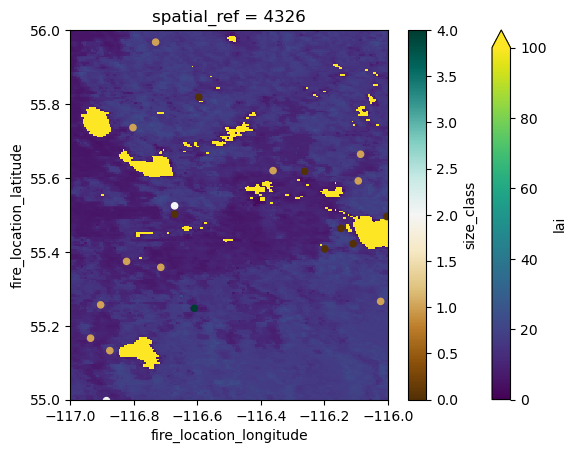

In [590]:
fig,ax = plt.subplots(1)

modis_dc.isel(time=30)['lai'].plot.imshow(vmin=0, vmax=100, ax=ax)

year = 2020
clipped = wf_df_train[(wf_df_train.fire_year == year)].copy()
clipped.size_class = clipped.size_class.map(ord) - 65
clipped.plot.scatter('fire_location_longitude','fire_location_latitude', c='size_class',cmap='BrBG', ax=ax)

plt.xlim([-117, -116])
plt.ylim([55, 56])

In [ ]:
fig,ax = plt.subplots(1)

modis_dc.isel(time=0)['lai'].plot.imshow(vmin=0,ax=ax)
can_epsg.boundary.plot(ax=ax)

In [246]:
roads = gdal.Open("C:\stuff_pract\CxC_hackaton\other_data\can_osm_dst_roadintersec_100m_2016.tif")

In [251]:
gt = roads.GetGeoTransform()

In [ ]:
roads.ReadAsArray().shape

In [256]:
roads_path = Path(r"C:\stuff_pract\CxC_hackaton\roads_tif\can_osm_dst_roadintersec_100m_2016.tif")

geo_info = (spatialreference, list((49752, 106061)), [gt[1], 0.0, gt[0], 0.0, gt[5], gt[3], 0.0, 0.0, 1.0])
datetime = pd.to_datetime(f"{2021}{1}", format='%Y%j').strftime("%Y-%m-%d %H:%M:%S.0000000Z")
uid = md5(str(roads_path).encode("utf-8")).hexdigest()
measurements = {'roads': {'path': str(roads_path)}}
metadata_file = eo3_dataset(f'roads', datetime=datetime, measurements=measurements, output_path=roads_path.parent, file_format="GeoTIFF", prefix=year, geo_info=geo_info, uuid_id=uid)     

In [169]:
res = 0.0045000045000045
query = {
    'product': 'roads',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
roads = dc.load(**query)

In [263]:
pop = gdal.Open("C:\stuff_pract\CxC_hackaton\pop_tif\ppp_2015_1km_Aggregated.tif")

In [264]:
pop.ReadAsArray().shape

(18720, 43200)

In [265]:
gt = pop.GetGeoTransform()

In [266]:
roads_path = Path(r"C:\stuff_pract\CxC_hackaton\pop_tif\ppp_2015_1km_Aggregated.tif")

geo_info = (spatialreference, list((18720, 43200)), [gt[1], 0.0, gt[0], 0.0, gt[5], gt[3], 0.0, 0.0, 1.0])
datetime = pd.to_datetime(f"{2021}{1}", format='%Y%j').strftime("%Y-%m-%d %H:%M:%S.0000000Z")
uid = md5(str(roads_path).encode("utf-8")).hexdigest()
measurements = {'pop': {'path': str(roads_path)}}
metadata_file = eo3_dataset(f'pop', datetime=datetime, measurements=measurements, output_path=roads_path.parent, file_format="GeoTIFF", prefix=year, geo_info=geo_info, uuid_id=uid)     

In [170]:
res = 0.0045000045000045
query = {
    'product': 'pop',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
pop = dc.load(**query)

In [74]:
joblib.dump(pop, 'pop.joblib')

['pop.joblib']

In [75]:
joblib.dump(roads, 'roads.joblib')

['roads.joblib']

In [73]:
era = xr.open_dataset(r'era5\era5_2021.nc')

In [659]:
pixel_width = era.longitude.diff(dim='longitude')[0].values.item()  # Avg difference between consecutive longitudes
pixel_height = -era.latitude.diff(dim='latitude')[0].values.item()

In [75]:
era

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 111, time: 730)
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.9 -119.8 ... -110.2 -110.1 -110.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 49.3 49.2 49.1 49.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-21 03:50:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [101]:
gt = [-120-0.09999847412109375/2, 0.09999847412109375, 0, 60+0.09999847412109375/ 2, 0, -0.09999847412109375]

spatialreference = osr.SpatialReference()
spatialreference.ImportFromEPSG(4326)                
spatialreference = str(spatialreference.ExportToPrettyWkt())


NameError: name 'osr' is not defined

In [79]:



for i in range(len(era.time)):
    measurements = {}
    for var_name in list(era.variables.mapping.keys())[3:]:
        
        datetime = pd.to_datetime(era.time[i].values)
        curr_year = datetime.year
        curr_doy = datetime.day_of_year
        hour = datetime.hour
        datetime = datetime.strftime("%Y-%m-%d %H:%M:%S.0000000Z")
        
        
        raster_array = era.isel(time=i)[var_name].values
        
        path_to_tif = Path(fr"C:\stuff_pract\CxC_hackaton\era_tif\{curr_year}\era_{var_name}_{curr_year}_{curr_doy}_{hour}.tif")
        
        crt_tif(raster_array=raster_array, destination=path_to_tif, geotransform=gt, spatialreference=spatialreference, nodata=np.iinfo(np.int32).min, dtype=gdal.GDT_Float32)
        
        measurements[var_name] = {'path': str(path_to_tif)}
        
    geo_info = (spatialreference, list(raster_array.shape), [gt[1], 0.0, gt[0], 0.0, gt[5], gt[3], 0.0, 0.0, 1.0])
    uid = md5(str(path_to_tif).encode("utf-8")).hexdigest()
    metadata_file = eo3_dataset(f'era5', datetime=datetime, measurements=measurements, output_path=path_to_tif.parent.parent, file_format="GeoTIFF", prefix=curr_year, geo_info=geo_info, uuid_id=uid)     

In [31]:
datetime

'2020-12-31 12:00:00.0000000Z'

In [31]:
dc = datacube.Datacube(app="era")

In [157]:
res=0.09999847412109375#0.0045000045000045
bounds = [-120, 49, -110, 60]
q_time=('2006', '2022')
# q_time=('2010')

In [158]:
query = {
    'product': 'era5',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': q_time,
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}

In [82]:
era_dc = dc.load(**query)

In [83]:
era_dc = era_dc.sel(time = era_dc.time[1::2])

In [84]:
b = 17.625
c = 243.04
humidity = 100 * np.exp(b*c*(era_dc['d2m'] - era_dc['t2m'])/((c+era_dc['t2m']-273.15)*(c+era_dc['d2m']-273.15)))
era_dc['hum'] = humidity
era_dc = era_dc.drop_vars('d2m')

new_order = ['tp', 't2m', 'hum', 'u10', 'v10']
era_dc = xr.Dataset({var: era_dc[var] for var in new_order})

In [9]:
era_dc

<xarray.Dataset>
Dimensions:      (time: 5844, latitude: 111, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2006-01-01T12:00:00 ... 2021-12-31T12:...
  * latitude     (latitude) float64 60.05 59.95 59.85 ... 49.25 49.15 49.05
  * longitude    (longitude) float64 -120.0 -119.9 -119.8 ... -110.1 -110.0
    spatial_ref  int32 4326
Data variables:
    tp           (time, latitude, longitude) float32 9.64e-05 ... 0.0001228
    t2m          (time, latitude, longitude) float32 264.7 265.0 ... 248.5 248.0
    hum          (time, latitude, longitude) float32 90.9 91.22 ... 66.37 66.32
    u10          (time, latitude, longitude) float32 -0.5192 -0.5341 ... 1.615
    v10          (time, latitude, longitude) float32 1.088 1.08 ... -1.708

In [87]:
joblib.dump(era_dc, "era_2006_2021.joblib")

['era_2006_2021.joblib']

In [171]:
era_dc = joblib.load("era_2006_2021.joblib")

In [7]:
res = 0.0045000045000045
query = {
    'product': 'era5',
    'output_crs': spatialreference,
    'resolution': (-res, res),
    'time': ('2021-6-1', '2021-9-1'),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
era_dc_test = dc.load(**query)
era_dc_test = era_dc_test.sel(time = era_dc_test.time[1::2])

In [10]:
joblib.dump(era_dc_test, "era_2021_test.joblib")

['era_2021_test.joblib']

In [2]:
era_dc_test = joblib.load("era_2021_test.joblib")

In [5]:
query = {
    'product': 'modis_lai',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': ('2021-5-15', '2021-9-15'),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
modis_dc_test = dc.load(**query)

In [9]:
joblib.dump(modis_dc_test, "modis_lai_2021_test.joblib")

['modis_lai_2021_test.joblib']

In [13]:
joblib.dump(modis_ndvi_dc_test, "modis_ndvi_2021_test.joblib")

['modis_ndvi_2021_test.joblib']

In [3]:
modis_dc_test = joblib.load("modis_lai_2021_test.joblib")
modis_ndvi_dc_test = joblib.load("modis_ndvi_2021_test.joblib")

In [16]:
query = {
    'product': 'modis_ndvi',
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': ('2021-5-10', '2021-9-20'),
    'lat': (bounds[1], bounds[3]),
    'lon': (bounds[0], bounds[2]),
}
modis_ndvi_dc_test = dc.load(**query)

In [4]:
era_dc_test['time'] = era_dc_test['time'] - pd.Timedelta(hours=12)

In [7]:
new_time = pd.date_range(start=modis_dc_test['time'].min().values, 
                         end=modis_dc_test['time'].max().values, 
                         freq='D')
modis_dc_test = modis_dc_test.interp(time=new_time)
modis_dc_test = modis_dc_test.sel(time=slice(pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-01")))

In [11]:
new_time = pd.date_range(start=modis_ndvi_dc_test['time'].min().values, 
                         end=modis_ndvi_dc_test['time'].max().values, 
                         freq='D')
modis_ndvi_dc_test = modis_ndvi_dc_test.interp(time=new_time)
modis_ndvi_dc_test = modis_ndvi_dc_test.sel(time=slice(pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-01")))

In [6]:

b = 17.625
c = 243.04
humidity = 100 * np.exp(b*c*(era_dc_test['d2m'] - era_dc_test['t2m'])/((c+era_dc_test['t2m']-273.15)*(c+era_dc_test['d2m']-273.15)))
era_dc_test['hum'] = humidity
era_dc_test = era_dc_test.drop_vars('d2m')

new_order = ['tp', 't2m', 'hum', 'u10', 'v10']

era_dc_test = xr.Dataset({var: era_dc_test[var] for var in new_order})


In [7]:
merged = xr.merge([era_dc_test, modis_dc_test, modis_ndvi_dc_test], compat='equals')

In [11]:
joblib.dump(merged, "merged.joblib")

['merged.joblib']

In [69]:
merged = joblib.load("merged.joblib")

In [70]:
merged


<xarray.Dataset>
Dimensions:      (time: 93, latitude: 2446, longitude: 2223)
Coordinates:
  * time         (time) datetime64[ns] 2021-06-01 2021-06-02 ... 2021-09-01
  * latitude     (latitude) float64 60.0 60.0 59.99 59.99 ... 49.01 49.0 49.0
  * longitude    (longitude) float64 -120.0 -120.0 -120.0 ... -110.0 -110.0
    spatial_ref  int32 4326
Data variables:
    tp           (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    t2m          (time, latitude, longitude) float32 287.5 287.5 ... 283.6 283.6
    hum          (time, latitude, longitude) float32 67.17 67.17 ... 52.2 52.2
    u10          (time, latitude, longitude) float32 1.929 1.929 ... 2.753 2.753
    v10          (time, latitude, longitude) float32 1.52 1.52 ... -1.943 -1.943
    lai          (time, latitude, longitude) float64 -3e+03 -3e+03 ... 4.75 4.75
    NDVI         (time, latitude, longitude) float64 -3e+03 -3e+03 ... 2.984e+03

In [21]:
merged_1 = merged.isel(time=slice(0, 31))

In [23]:
arr = merged_1.stack(spatial=('latitude', 'longitude')).to_array().values 

In [ ]:
arr.shape

In [89]:
dastetime = [pd.to_datetime(date).day_of_year / 365 for date in era_dc_test.time.values]
dastetime = np.array(dastetime).reshape(1, 37, 1)
result_array = np.concatenate((arr.T, dastetime.repeat(arr.T.shape[0], axis=0)), axis=2)


In [102]:
np.save('all_state_2010_06.npy', result_array)

In [ ]:
# month_dataset = []
# date = pd.to_datetime("2010-07-01")

# for i, lat in enumerate(modis_dc_2010.latitude):
#     print(lat.values)

#     for j, lon in enumerate(modis_dc_2010.longitude):

#         # date_idx = np.argmax((era_dc.time == era_dc.sel(time=date, method='nearest').time).values)
#         # modis_data = modis_dc.sel(latitude = lat, longitude=lon).isel(time=slice(date_idx-lag, date_idx+5))
#         # era_data = era_dc.sel(latitude = lat, longitude=lon, method="nearest").isel(time=slice(date_idx-lag, date_idx+5))
#         era_lag_ = calc_era_lag(lat, lon, date, era_dc, modis_dc_2010)
#         if era_lag_ is None or len(era_lag_) != 37:
#             print(len(era_lag_))
#             continue
    
#         month_dataset.append(era_lag_)
        

In [29]:
clipped[['fire_location_longitude','fire_location_latitude']].to_numpy()


array([[-119.926971,   59.522139],
       [-116.63812 ,   55.895495],
       [-116.87215 ,   54.337717],
       [-113.670517,   54.801033],
       [-116.186615,   54.701932],
       [-118.2442  ,   59.052333],
       [-118.324812,   59.066263],
       [-119.930297,   59.293714],
       [-119.581873,   59.657522],
       [-117.461328,   59.338288],
       [-113.388867,   57.802733],
       [-113.1298  ,   57.782283],
       [-110.587017,   56.67165 ],
       [-119.492167,   58.445333],
       [-115.198943,   53.302585],
       [-114.558533,   52.74865 ]])

In [21]:
clipped

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares


<Axes: title={'center': 'time = 2021-07-12 [seconds since 1970-01-01 00:...'}, xlabel='fire_location_longitude', ylabel='fire_location_latitude'>

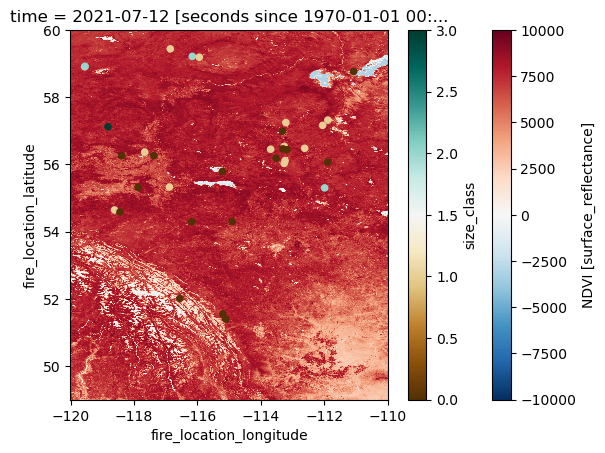

In [18]:
fig,ax = plt.subplots(1)
(modis_ndvi_dc_test.isel(time=3)['NDVI']).plot.imshow(ax=ax)


year = 2020
clipped = wf_df_years[(wf_df_years.fire_year == 2021) & (wf_df_years.fire_start_date.dt.month == 8)
                      & (wf_df_years.fire_start_date.dt.day >= 1) & (wf_df_years.fire_start_date.dt.day <= 3)].copy()
clipped.size_class = clipped.size_class.map(ord) - 65
clipped.plot.scatter('fire_location_longitude','fire_location_latitude', c='size_class',cmap='BrBG', ax=ax)




<Axes: title={'center': 'time = 2010-05-09 [seconds since 1970-01-01 00:...'}, xlabel='fire_location_longitude', ylabel='fire_location_latitude'>

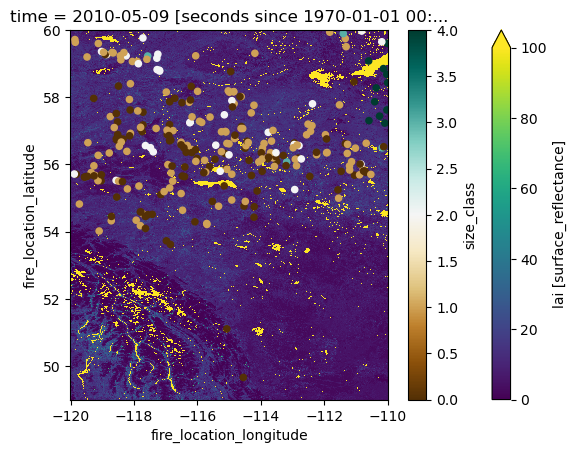

In [47]:
fig,ax = plt.subplots(1)
(modis_dc.isel(time=200)['lai']).plot.imshow(ax=ax, vmax=100)


year = 2020
clipped = wf_df_years[(wf_df_years.fire_year == 2010) & (wf_df_years.fire_start_date.dt.month == 7)].copy()
clipped.size_class = clipped.size_class.map(ord) - 65
clipped.plot.scatter('fire_location_longitude','fire_location_latitude', c='size_class',cmap='BrBG', ax=ax)




In [198]:
wf_df_train = wf_df.copy()
wf_df_train = wf_df_train[~pd.isnull(pd.to_datetime(wf_df_train['fire_start_date'], errors='coerce'))]

In [24]:
wf_df_train.fire_start_date = pd.to_datetime(wf_df_train.fire_start_date)

In [13]:
wf_df = pd.read_excel('fp-historical-wildfire-data-2006-2021.xlsx')

In [698]:
fire_size_train = []
fire_size_train_labels = []


In [346]:
lag = 32

In [690]:
years = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]
wf_df_years = wf_df[(wf_df.fire_year.isin(years)) & (wf_df.general_cause_desc=='Lightning') & (wf_df.size_class != 'E') & (wf_df.current_size > 0.01)]

In [691]:
wf_df_years.fire_start_date = pd.to_datetime(wf_df_years.fire_start_date, errors='coerce')

C:\Users\maxim\AppData\Local\Temp\ipykernel_11424\3853074217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_df_years.fire_start_date = pd.to_datetime(wf_df_years.fire_start_date, errors='coerce')


In [348]:
def interpolate_modis(row_lat, row_lon, era_lag, modis_dc, prodcut, day_gap):
    addup = day_gap + 1
    seven_days = pd.Timedelta(days=day_gap, hours=12)
    epsilion = 1e-7
    lai_values = modis_dc.sel(latitude = row_lat, longitude=row_lon, method='nearest').sel(time=slice(era_lag.time[0]-seven_days, era_lag.time[-1]+seven_days))[prodcut]
    lai_values = lai_values.astype(float) + epsilion
    location_mask = np.array([time_date.values in era_lag.time.sel(time = lai_values.time[1:-1], method='nearest') for time_date in era_lag.time]).astype(float)
    true_locations = np.where(location_mask)[0]
    location_mask_len = len(location_mask)
    add_to_begining = np.max([0, addup-true_locations[0]])
    location_mask = np.concatenate([[0] * add_to_begining,location_mask ,[0] * (addup - (len(location_mask) - true_locations[-1] - 1))])
    location_mask[0] = 1
    location_mask[-1] = 1

    location_mask[np.where(location_mask)[0]] = lai_values

    a = pd.Series(location_mask)
    a.replace(0, np.NaN, inplace=True)
    a = a.interpolate()
    a = a - epsilion

    a = a[add_to_begining:location_mask_len+add_to_begining].values
    return a

In [349]:
def calc_era_lag(row_lat, row_lon, row_time, era_dc, modis_dc, modis_ndvi_dc):
    date_idx = np.argmax((era_dc.time == era_dc.sel(time=row_time, method='nearest').time).values)
    era_lag = era_dc.sel(latitude = row_lat, longitude=row_lon, method='nearest').isel(time=slice(date_idx-lag, date_idx))
    
    if len(era_lag) == 0:
        return None
    # b = 17.625
    # c = 243.04
    # humidity = 100 * np.exp(b*c*(era_lag['d2m'] - era_lag['t2m'])/((c+era_lag['t2m']-273.15)*(c+era_lag['d2m']-273.15)))
    
    modis_lag_lai = interpolate_modis(row_lat, row_lon, era_lag, modis_dc, 'lai', 7)
    modis_lag_ndvi = interpolate_modis(row_lat, row_lon, era_lag, modis_ndvi_dc, 'NDVI', 15)
    
    dastetime = [pd.to_datetime(date).day_of_year / 365 for date in era_lag.time.values]
    
    population = pop.sel(latitude=row_lat, longitude=row_lon, method='nearest').isel(time=0)['pop'].values
    road = roads.sel(latitude=row_lat, longitude=row_lon, method='nearest').isel(time=0)['roads'].values
    

    era_lag_ = np.vstack([era_lag['tp'].values, 
            era_lag['t2m'].values, 
            era_lag['hum'].values, 
            # humidity.values, 
            era_lag['u10'].values,
            era_lag['v10'].values, 
            modis_lag_lai,
            modis_lag_ndvi,
            dastetime,
            population.repeat(lag),
            road.repeat(lag),]).T
   
    return era_lag_
    

In [290]:

wf_df_years = wf_df.copy()
wf_df_years.loc[1291, 'fire_start_date'] = wf_df_years.loc[1291, 'fire_start_date'].replace('1021', '2021')
wf_df_years.loc[14316, 'fire_start_date'] = wf_df_years.loc[14316, 'fire_start_date'].replace('0201', '2011')
wf_df_years['fire_start_date'] = pd.to_datetime(wf_df_years['fire_start_date'])

years = np.arange(2006, 2022)#[2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2010]
# wf_df_years[(wf_df_years.current_size < 0.1)& (wf_df_years.general_cause_desc=='Lightning') & (wf_df_years.fire_spread_rate>=1)]
wf_df_years = wf_df_years[((wf_df_years.fire_year.isin(years)) & (wf_df_years.current_size >= 0.1)) | ((wf_df_years.current_size < 0.1)& (wf_df_years.general_cause_desc=='Lightning') & (wf_df_years.fire_spread_rate>=1))]
# wf_df_years = wf_df_years[(wf_df_years.fire_year.isin(years)) & (wf_df_years.current_size > 0.5) | (wf_df_years.distance_from_water_source > 0)]
# wf_df_years = wf_df_years[(~pd.isna(wf_df_years.fire_fighting_start_size) | (wf_df_years.current_size > 1)) & (wf_df_years.current_size > 0.1)]
wf_df_years = wf_df_years[((wf_df_years.activity_class == 'Debris Disposal') & (wf_df_years.current_size > 1)) | (wf_df_years.activity_class != 'Debris Disposal')]
wf_df_years = wf_df_years[((wf_df_years.general_cause_desc == 'Incendiary') & (wf_df_years.current_size > 1.5)) | (wf_df_years.general_cause_desc != 'Incendiary')]

# wf_df_years.fire_start_date = pd.to_datetime(wf_df_years.fire_start_date, errors='coerce')

In [341]:
wf_df_years = wf_df.copy()
wf_df_years.loc[1291, 'fire_start_date'] = wf_df_years.loc[1291, 'fire_start_date'].replace('1021', '2021')
wf_df_years.loc[14316, 'fire_start_date'] = wf_df_years.loc[14316, 'fire_start_date'].replace('0201', '2011')
wf_df_years['fire_start_date'] = pd.to_datetime(wf_df_years['fire_start_date'])

wf_df_years = wf_df_years[(np.abs(wf_df_years.current_size - wf_df_years.assessment_hectares) > 0.0)|(wf_df_years.current_size>0.1)]

wf_df_years = wf_df_years[((wf_df_years.activity_class == 'Debris Disposal') & (wf_df_years.current_size > 1)) | (wf_df_years.activity_class != 'Debris Disposal')]
wf_df_years = wf_df_years[((wf_df_years.general_cause_desc == 'Incendiary') & (wf_df_years.current_size > 1)) | (wf_df_years.general_cause_desc != 'Incendiary')]


In [350]:
fire_size_train = []
fire_size_train_labels = []

data_years = []

for idx, row in wf_df_years.iterrows():
    
    row_lat = row.fire_location_latitude
    row_lon = row.fire_location_longitude
    if (row.fire_start_date is pd.NaT) or np.abs((row.assessment_datetime - row.fire_start_date).days) > 80:
        row_time = row.assessment_datetime
        if row_time is pd.NaT:
            continue
    else:
        row_time = row.fire_start_date

    date_idx = np.argmax((era_dc.time == era_dc.sel(time=row_time, method='nearest').time).values)
    era_lag = era_dc.sel(latitude = row_lat, longitude=row_lon, method='nearest').isel(time=slice(date_idx-lag, date_idx))
    
    if len(era_lag.time) != 32:
        continue


    # b = 17.625
    # c=243.04
    # humidity = 100 * np.exp(b*c*(era_lag['d2m'] - era_lag['t2m'])/((c+era_lag['t2m']-273.15)*(c+era_lag['d2m']-273.15)))
    
    
    # modis_lag = interpolate_modis(row_lat, row_lon, era_lag, modis_dc)
    
    
    # era_lag_ = np.vstack([era_lag['tp'].values, 
    #         era_lag['t2m'].values, 
    #         humidity.values, 
    #         era_lag['u10'].values,
    #         era_lag['v10'].values, 
    #         modis_lag]).T
    
    era_lag_ = calc_era_lag(row_lat, row_lon, row_time, era_dc, modis_dc, modis_ndvi_dc)
    
    if era_lag_ is None or len(era_lag_) != 32:
        print(len(era_lag_))
        continue
    
    fire_size_train.append(era_lag_)
    # fire_size_train_labels.append(ord(row.size_class)- 65)
    fire_size_train_labels.append(row.current_size)
    data_years.append(row_time.year)


    

In [238]:
data_years = []
for idx, row in wf_df_years.iterrows():
    if (row.fire_start_date is pd.NaT) or np.abs((row.assessment_datetime - row.fire_start_date).days) > 80:
        row_time = row.assessment_datetime
        if row_time is pd.NaT:
            continue
    else:
        row_time = row.fire_start_date
        
    date_idx = np.argmax((era_dc.time == era_dc.sel(time=row_time, method='nearest').time).values)
    era_lag = era_dc.sel(latitude = row_lat, longitude=row_lon, method='nearest').isel(time=slice(date_idx-lag, date_idx+5))
    if len(era_lag.time) != 32:
        continue
    data_years.append(row_time.year)

In [351]:
len(data_years)

7608

In [352]:
len(fire_size_train)

7608

In [353]:
np.array(fire_size_train).shape

(7608, 32, 10)

In [54]:
np.where(~np.isfinite(fire_size_train))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [354]:
np.save('fire_size_train_allyears_roadapop_new.npy', fire_size_train)

In [355]:
np.save('fire_size_train_labels_allyears_roadapop_new.npy', fire_size_train_labels)

In [57]:
np.array(fire_size_train).shape

(5409, 37, 10)

In [358]:
data_years_cpy = data_years.copy()

In [359]:
fire_negative_train = []



fire_masks = {}
for year in range(2006, 2022):
    print(year)
    # wf_df_year = wf_df[(wf_df.fire_year == year) & (wf_df.current_size > 0.01)]
    # wf_df_year = wf_df_year[((wf_df_year.general_cause_desc == 'Incendiary') & (wf_df_year.current_size > 1)) | (wf_df_year.general_cause_desc != 'Incendiary')]
    wf_df_years_local = wf_df_years[(wf_df_years.fire_year == year)]
    
    fire_mask = modis_dc.isel(time=0)['lai']
    fire_mask = fire_mask.where(fire_mask < -1, 0)
    fire_mask = set_mask(alberta.geometry, fire_mask.crs, None, fire_mask)
    fire_mask = fire_mask.fillna(1)
    # print("fire mask")
    for idx, row in wf_df_years_local.iterrows():
        row_lat = row.fire_location_latitude
        row_lon = row.fire_location_longitude
        
        lon = fire_mask.sel(latitude = row_lat, longitude = row_lon, method='nearest').longitude
        lat = fire_mask.sel(latitude = row_lat, longitude = row_lon, method='nearest').latitude

        lat_idx = np.where(fire_mask.latitude == lat)[0][0]
        lon_idx = np.where(fire_mask.longitude == lon)[0][0]
        if row.current_size < 1:
            patch = 2
        elif row.current_size < 100: 
            patch = 10
        else:
            patch = 32
        fire_mask[slice(lat_idx-patch, lat_idx+patch), slice(lon_idx-patch, lon_idx+patch)] = 1
    fire_masks[year] = fire_mask
    # print("random dots")
    
    random_points = []
    while(len(random_points) < wf_df_years_local.shape[0]*2):
        rnd_lat = np.random.uniform(low=fire_mask.latitude[0].values, high=fire_mask.latitude[-1].values)
        rnd_lon = np.random.uniform(low=fire_mask.longitude[0].values, high=fire_mask.longitude[-1].values)
        if fire_mask.sel(latitude = rnd_lat, longitude = rnd_lon, method='nearest').values == 0:
            random_points.append([rnd_lat, rnd_lon])
    random_points = np.array(random_points)
    # print(random_points.shape)
    
    # print("calc era")
    for points in random_points:
        fire_range = (wf_df_years_local.assessment_datetime.max() - wf_df_years_local.assessment_datetime.min()).days
        random_days = np.random.randint(32, fire_range)
        random_date = wf_df_years_local.assessment_datetime.min() + pd.Timedelta(days=random_days)
        era_lag_ = calc_era_lag(points[0], points[1], random_date, era_dc, modis_dc, modis_ndvi_dc)
        
        if len(era_lag_) != 32:
            print(len(era_lag_))
            continue
        fire_negative_train.append(era_lag_)
        data_years.append(year)
        


2006


2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [240]:
for year in range(2006, 2021):
    wf_df_years_local = wf_df_years[(wf_df_years.fire_year == year)]
    data_years.extend([year] * wf_df_years_local.shape[0]*2)

In [362]:
len(data_years)

22830

In [364]:
np.save('data_years_roadapop_new.npy', data_years)

In [68]:
np.array(fire_negative_train).shape

(10820, 37, 10)

In [57]:
np.where(~np.isfinite(fire_negative_train))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [361]:
np.save('fire_negative_train_alldata_roadapop_new.npy', fire_negative_train)

In [60]:
import geopandas as gpd

In [107]:
alberta = gpd.read_file(r".\canada_province\gpr_000b11a_e.shp")

In [108]:
alberta = alberta.iloc[10]

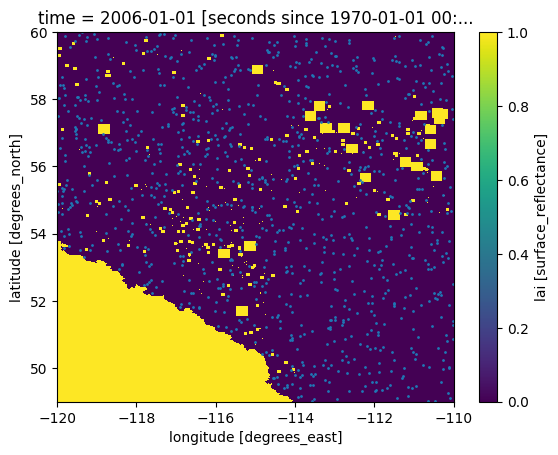

In [360]:
fire_mask.plot.imshow()
plt.scatter(random_points[:, 1], random_points[:, 0], s=1)
# plt.xlim(-116, -115.8)
# plt.ylim(52.8, 52.9)

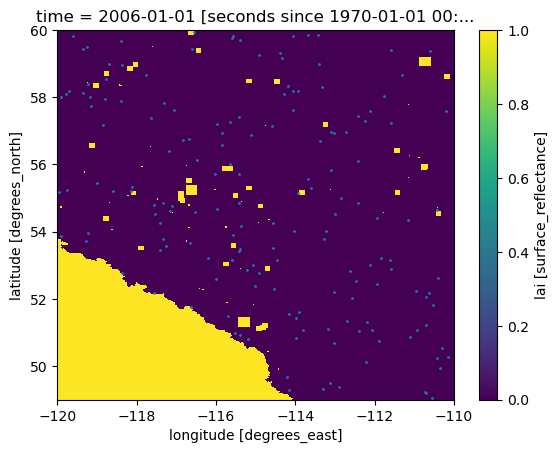

In [67]:
fire_mask.plot.imshow()
plt.scatter(random_points[:, 1], random_points[:, 0], s=1)
# plt.xlim(-116, -115.8)
# plt.ylim(52.8, 52.9)

In [972]:
fire_mask.longitude[0].values, fire_mask.longitude[-1].values,

(array(-119.99937), array(-110.00036))

In [975]:
rnd_lat, rnd_lon

(55.05009553675471, -114.52853106392838)

<Axes: title={'center': 'time = 2019-02-05T12:00:00 [seconds since 1970-...'}, xlabel='fire_location_longitude', ylabel='fire_location_latitude'>

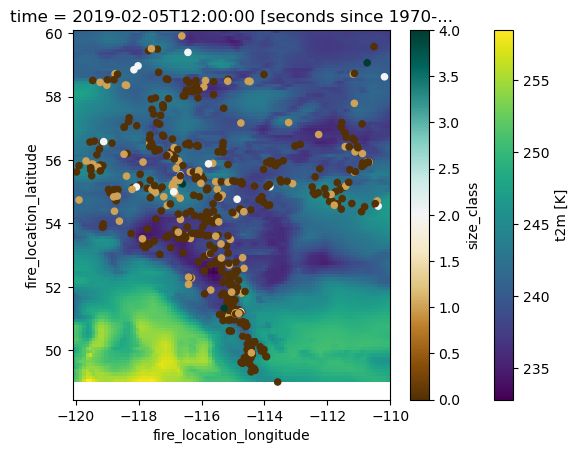

In [199]:
fig,ax = plt.subplots(1)
(era_dc.isel(time=400)['t2m']).plot.imshow(ax=ax)


year = 2020
clipped = wf_df_train[(wf_df_train.fire_year == year)].copy()
clipped.size_class = clipped.size_class.map(ord) - 65
clipped.plot.scatter('fire_location_longitude','fire_location_latitude', c='size_class',cmap='BrBG', ax=ax)
# for item in clipped.iterrows():
#     item = item[1]
#     ax.annotate(str(item.fire_start_date )+ " " + item.general_cause_desc[:5], (item.fire_location_longitude, item.fire_location_latitude), fontsize=5)
    
    
# plt.xlim([-117, -116])
# plt.ylim([55, 56])

In [ ]:
clipped[clipped.size_class == 3].reported_date.hist(bins=50, figsize=(20,15), ec = 'b')
plt.show()

In [13]:
nearest_era = era_dc.sel(latitude = 59.522139, longitude=-119.926971, method='nearest')

In [ ]:
nearest_era

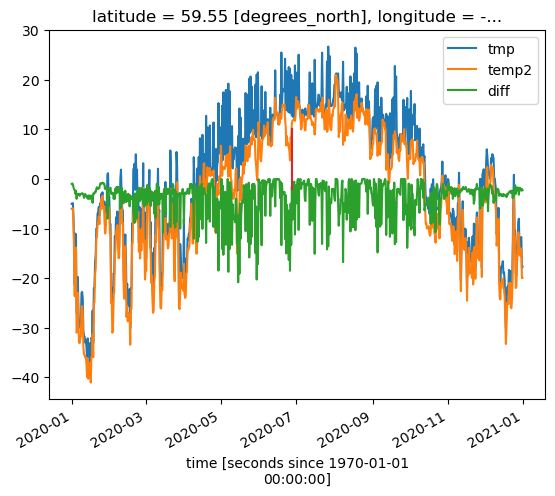

In [103]:
nearest_era = era_dc.sel(latitude = 59.522139, longitude=-119.926971, method='nearest')
# ((nearest_era['t2m']-nearest_era['t2m'].mean())/nearest_era['t2m'].std()).plot(label='tmp')
# ((nearest_era['d2m']-nearest_era['d2m'].mean())/nearest_era['d2m'].std()).plot(label='temp2')
# ((nearest_era['tp']-nearest_era['tp'].mean())/nearest_era['tp'].std()).plot(label='tp')
# ((nearest_era['u10']-nearest_era['u10'].mean())/nearest_era['u10'].std()).plot(label='uw')
# ((nearest_era['v10']-nearest_era['v10'].mean())/nearest_era['v10'].std()).plot(label='vw')
(nearest_era['t2m']-270).plot(label='tmp')
(nearest_era['d2m']-270).plot(label='temp2')
(nearest_era['d2m']-nearest_era['t2m']).plot(label='diff')
plt.plot([pd.to_datetime("2020-06-28"), pd.to_datetime("2020-06-28")], [-2, 10])
plt.legend()

In [133]:
date_idx = np.argmax((era_dc.time == era_dc.sel(time='2020-06-13 16:00:00', method='nearest').time).values)

In [138]:
era_dc.isel(time=slice(date_idx-64, date_idx))

<xarray.Dataset>
Dimensions:      (time: 64, latitude: 111, longitude: 101)
Coordinates:
  * time         (time) datetime64[ns] 2020-05-12T12:00:00 ... 2020-06-13
  * latitude     (latitude) float64 60.05 59.95 59.85 ... 49.25 49.15 49.05
  * longitude    (longitude) float64 -120.0 -119.9 -119.8 ... -110.1 -110.0
    spatial_ref  int32 4326
Data variables:
    t2m          (time, latitude, longitude) float32 276.6 276.6 ... 292.0 292.0
    u10          (time, latitude, longitude) float32 0.204 0.2012 ... -6.0 -6.0
    v10          (time, latitude, longitude) float32 1.963 2.004 ... 1.0 2.0
    tp           (time, latitude, longitude) float32 1.665e-06 1.665e-06 ... 0.0
    d2m          (time, latitude, longitude) float32 267.9 267.8 ... 282.0 282.0
Attributes:
    crs:           GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID[...
    grid_mapping:  spatial_ref

In [20]:
b = 17.625
c=243.04
humidity = 100 * np.exp(b*c*(nearest_era['d2m'] - nearest_era['t2m'])/((c+nearest_era['t2m']-273)*(c+nearest_era['d2m']-273)))

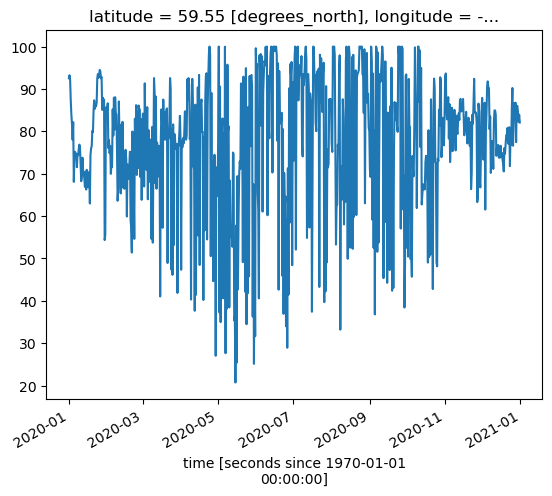

In [25]:
humidity.plot()

In [3]:
import geopandas as gpd

In [4]:
burned_areas = gpd.read_file(r'.\burned_areas\nbac_1986_to_2022_20230630.shp')

In [5]:
burned_areas

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,1986.0,208.0,1.0,9.0,7.0,2.0,4.0,None,None,1986-07-10,None,1986-09-12,3408.092664,3408.092664,0.0,NT,12.0,1986_r9_20210810,Null,"POLYGON ((-1409877.875 1922967.375, -1409851.5..."
1,1986.0,31.0,1.0,9.0,7.0,4.0,4.0,None,None,1986-05-14,None,1986-06-20,2767.768044,2767.768044,0.0,NB,8.0,1986_r9_20210810,Null,"POLYGON ((2168531.000 357519.562, 2168557.000 ..."
2,1986.0,159.0,3.0,0.0,2.0,4.0,4.0,None,None,1986-05-28,None,None,49.268235,53.316641,2.0,BC,241.0,1986_r9_20210810,"G70001[load_date:20070517000000,method:digitis...","POLYGON ((-1544570.746 1040207.707, -1544573.7..."
3,1986.0,102.0,3.0,0.0,2.0,4.0,4.0,None,None,1986-10-20,None,None,6.743968,7.880180,2.0,BC,269.0,1986_r9_20210810,"C50101[load_date:20070517000000,method:digitis...","POLYGON ((-1886518.162 724938.138, -1886574.77..."
4,1986.0,13.0,1.0,9.0,7.0,2.0,4.0,None,None,1986-05-27,None,1986-07-30,1882.734463,1882.734463,0.0,QC,17.0,1986_r9_20210810,Null,"MULTIPOLYGON (((1339406.750 269544.312, 133941..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38251,2022.0,1310.0,3.0,0.0,0.0,3.0,4.0,None,None,2022-05-12,None,None,75.759431,69.526772,2.0,PC-LM,807.0,2022_r12_20230630,None,"MULTIPOLYGON (((1666081.615 43086.973, 1666036..."
38252,2022.0,1296.0,3.0,2.0,0.0,4.0,4.0,None,None,2022-06-30,2022-06-30,None,0.000989,0.001400,2.0,PC-BA,862.0,2022_r12_20230630,None,"POLYGON ((-1433731.896 508400.325, -1433732.17..."
38253,2022.0,1302.0,3.0,2.0,0.0,3.0,4.0,None,None,2022-07-24,2022-08-06,None,2.552444,2.669864,2.0,PC-GL,857.0,2022_r12_20230630,None,"MULTIPOLYGON (((-1517421.832 543371.109, -1517..."
38254,2022.0,1027.0,3.0,0.0,0.0,2.0,4.0,None,None,None,None,None,87.387200,79.757293,2.0,ON,869.0,2022_r12_20230630,None,"POLYGON ((988979.192 -137069.574, 988969.470 -..."


In [6]:
burned_areas = burned_areas[burned_areas['YEAR'] >= 2006].reset_index(drop=True)
burned_areas = burned_areas[burned_areas['YEAR'] <= 2021].reset_index(drop=True)

In [7]:
burned_areas = burned_areas[burned_areas['AGENCY'] == 'AB'].reset_index(drop=True)

In [8]:
burned_areas = burned_areas.to_crs(epsg=4326)

In [9]:
from shapely.geometry import Point

In [14]:

wf_df_poly = wf_df.copy()
wf_df_poly.loc[1291, 'fire_start_date'] = wf_df_poly.loc[1291, 'fire_start_date'].replace('1021', '2021')
wf_df_poly.loc[14316, 'fire_start_date'] = wf_df_poly.loc[14316, 'fire_start_date'].replace('0201', '2011')
wf_df_poly['fire_start_date'] = pd.to_datetime(wf_df_poly['fire_start_date'])

years = np.arange(2006, 2022)
wf_df_poly = wf_df_poly[(wf_df_poly.fire_year.isin(years)) & (wf_df_poly.current_size > 0.01)]
wf_df_poly = wf_df_poly[(~pd.isna(wf_df_poly.fire_fighting_start_size) | (wf_df_poly.current_size > 1)) & (wf_df_poly.current_size > 0.1)]
wf_df_poly = wf_df_poly[((wf_df_poly.general_cause_desc == 'Incendiary') & (wf_df_poly.current_size > 1)) | (wf_df_poly.general_cause_desc != 'Incendiary')]


In [14]:
from shapely import affinity

In [ ]:
# poly_pairs = []
# for idx in range(len(burned_areas)):
#     coordinates = np.array(burned_areas.iloc[idx].geometry.centroid.xy).T[0][::-1]
#     wf_df_poly_year = wf_df_poly[wf_df_poly.fire_year == burned_areas.iloc[idx]['YEAR']]
#     dist = wf_df_poly_year[['fire_location_latitude', 'fire_location_longitude']] - coordinates
#     dist['dist'] = np.sqrt(dist['fire_location_latitude']**2 + dist['fire_location_longitude']**2)
#     min_idx = np.argmin(dist['dist'].values)
#     if np.min(dist['dist']) > 0.01:
#         p = Point(wf_df_poly_year.iloc[min_idx].fire_location_longitude, wf_df_poly_year.iloc[min_idx].fire_location_latitude)
#         distance = burned_areas.iloc[idx].geometry.convex_hull.exterior.distance(p)
#         if distance < 0.015 or burned_areas.iloc[idx].geometry.convex_hull.contains(p) or distance/np.min(dist['dist']) < 0.6:
#             poly_pairs.append((burned_areas.iloc[idx], wf_df_poly_year.iloc[min_idx]))
#         else:
#             print(np.min(dist['dist']), idx, np.argmin(dist['dist'].values), distance, burned_areas.iloc[idx]['POLY_HA']) 
#     else:
#         poly_pairs.append((burned_areas.iloc[idx], wf_df_poly_year.iloc[min_idx]))
#     # print(c)

In [156]:
poly_pairs = []
for idx in range(len(burned_areas)):
    
    if burned_areas.iloc[idx]['POLY_HA'] < 4:
        continue
    
    coordinates = np.array(burned_areas.iloc[idx].geometry.centroid.xy).T[0][::-1]
    try:
        wf_df_closestdate = wf_df_poly[np.abs(wf_df_poly.assessment_datetime - pd.to_datetime(burned_areas.iloc[idx]['AFSDATE'])) < pd.Timedelta(days=2)]
    except:
        print('EXCEPT')
        wf_df_closestdate = wf_df_poly[wf_df_poly.fire_year == burned_areas.iloc[idx]['YEAR']]
         
    dist = wf_df_closestdate[['fire_location_latitude', 'fire_location_longitude']] - coordinates
    if len(dist) == 0:
        continue
    
    dist['dist'] = np.sqrt(dist['fire_location_latitude']**2 + dist['fire_location_longitude']**2)
    min_idx = np.argmin(dist['dist'].values)
    
    
    
    
    
    if np.min(dist['dist']) > 0.01:
        p = Point(wf_df_closestdate.iloc[min_idx].fire_location_longitude, wf_df_closestdate.iloc[min_idx].fire_location_latitude)
        distance = burned_areas.iloc[idx].geometry.convex_hull.exterior.distance(p)
        if distance < 0.01 or burned_areas.iloc[idx].geometry.convex_hull.contains(p) or distance/np.min(dist['dist']) < 0.6:
            max_ha = max(burned_areas.iloc[idx]['POLY_HA'], wf_df_closestdate.iloc[min_idx].current_size)
            min_ha = min(burned_areas.iloc[idx]['POLY_HA'], wf_df_closestdate.iloc[min_idx].current_size)
            if (min_ha/max_ha) > 0.5:
                poly_pairs.append((burned_areas.iloc[idx], wf_df_closestdate.iloc[min_idx]))
            else:
                print(max_ha, min_ha)
        else:
            # if wf_df_closestdate.iloc[min_idx].fire_name is not np.nan and \
            # burned_areas.iloc[idx]['COMMENTS'] is not None and \
            # wf_df_closestdate.iloc[min_idx].fire_name.strip() in burned_areas.iloc[idx]['COMMENTS']:
            #     print(wf_df_closestdate.iloc[min_idx].fire_name.strip(),distance,\
            #         wf_df_closestdate.iloc[min_idx].fire_number, burned_areas.iloc[idx]['COMMENTS'],\
            #         wf_df_closestdate.iloc[min_idx].current_size, burned_areas.iloc[idx]['POLY_HA'],)
                
            #     poly_pairs.append((burned_areas.iloc[idx], wf_df_closestdate.iloc[min_idx]))
            #     continue
            print(np.min(dist['dist']), idx, np.argmin(dist['dist'].values), distance, burned_areas.iloc[idx]['POLY_HA']) 
    else:
        max_ha = max(burned_areas.iloc[idx]['POLY_HA'], wf_df_closestdate.iloc[min_idx].current_size)
        min_ha = min(burned_areas.iloc[idx]['POLY_HA'], wf_df_closestdate.iloc[min_idx].current_size)
        if (min_ha/max_ha) > 0.5:
                poly_pairs.append((burned_areas.iloc[idx], wf_df_closestdate.iloc[min_idx]))
        else:
            print(max_ha, min_ha, '  but close')
    # print(c)

5568.94499402 1745.0
1679.80410581 1.0
19.3248921084 1.0
7400.0 170.242774177
5231.18452457 6.5
0.051963516316155006 10 29 0.04133120624953411 75.5654561917
2564.76494749 5.3
1600.0 22.6364465293   but close
0.9372084202436103 25 54 0.8701838205612699 4089.85313428
948.5 19.8958435861
1345.08498403 73.6
1786.0 23.5769933878
165.6 20.9929079311   but close
EXCEPT
0.5448900932127144 35 214 0.5361765899420727 157.847419461
11.6553889599 3.0   but close
3274.0 5.53530824397
126.0 5.72219089739   but close
165.6 11.9150063847   but close
0.0476907837719204 58 11 0.04310645586536207 6.3027766472
1292.9 19.9191337981
0.03331615987955337 62 53 0.024752735685857834 4.876411494
0.13682672032428503 63 0 0.1315166546515384 7.4559931662
126.0 11.6264313942
2531.0 12.2964044337
0.07476311734163782 66 63 0.05036338921473249 15.173531478
21.8275247801 6.5
73.6 28.2811703831   but close
0.061010212655380036 88 9 0.04755976949405071 5.95633223835
67.8 15.7884723042   but close
0.02101751323859826 98 37 

In [155]:
len(poly_pairs)

1264

In [42]:
x1, y1 = burned_areas[burned_areas['POLY_HA']==33252.8838839].iloc[0].geometry.convex_hull.exterior.xy

In [44]:
burned_areas[burned_areas['POLY_HA']==33252.8838839]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
1071,2011.0,106.0,3.0,4.0,2.0,0.0,2.0,2011-05-14,2011-07-06,2011-05-14,2012-01-04,2011-09-09,33252.883884,33252.883884,0.0,AB,644.0,2011_r9_20210810,"MWF-007-2011[alias:Richardson Fire,pt_repdate:...","MULTIPOLYGON (((-111.62368 57.19860, -111.6240..."


In [54]:
wf_df_poly[wf_df_poly.current_size ==577646.8].fire_name.iloc[0].strip() in burned_areas[burned_areas['POLY_HA']==33252.8838839]['COMMENTS'].iloc[0]

True

In [52]:
burned_areas[burned_areas['POLY_HA']==33252.8838839]['COMMENTS'].iloc[0]

'MWF-007-2011[alias:Richardson Fire,pt_repdate:2011-05-14,pt_extdate:2012-01-04,fire_class:E,burncode:PB,burn_class:3,capture_da:2011-09-09,time:1200,pt_cause:Undetermined,source:5 - digitized from aerial photo] [...]'

In [53]:
wf_df_poly[wf_df_poly.current_size ==577646.8].fire_name.iloc[0].strip()

'Richardson Fire'

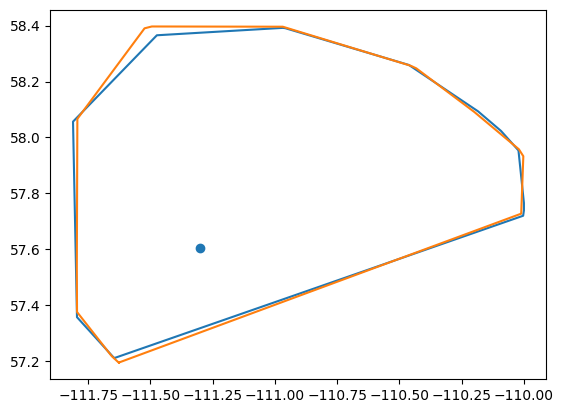

In [43]:
plt.plot(x, y)
plt.plot(x1, y1)
plt.scatter([-111.301272], [57.603559])

In [45]:
wf_df_poly[wf_df_poly.current_size ==577646.8]#.assessment_datetime

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
13380,2011,MWF007,Richardson Fire,577646.8,E,57.603559,-111.301272,Provincial Land,Undetermined,NaN,...,10.0,2011-05-14 17:45:00,2011-06-20 08:10:00,602417.0,2011-08-15 14:24:00,707648.0,NaT,NaN,2012-01-04 11:57:00,577646.8


994

In [50]:
burned_areas.iloc[idx]

YEAR                                                   2015.0
NFIREID                                                2113.0
BASRC                                                     3.0
FIREMAPS                                                  2.0
FIREMAPM                                                  3.0
FIRECAUS                                                  2.0
BURNCLAS                                                  4.0
SDATE                                                    None
EDATE                                                    None
AFSDATE                                            2015-07-01
AFEDATE                                                  None
CAPDATE                                            2015-07-09
POLY_HA                                              6.628693
ADJ_HA                                               7.750638
ADJ_FLAG                                                  2.0
AGENCY                                                     AB
BT_GID  

In [63]:
len(poly_pairs)

2132

In [21]:
idx = 1088
datediff = pd.to_datetime(poly_pairs[idx][0]['AFSDATE']) - poly_pairs[idx][1].assessment_datetime

coordinates = np.array(poly_pairs[idx][0].geometry.centroid.xy).T[0][::-1]
dist = poly_pairs[idx][1][['fire_location_latitude', 'fire_location_longitude']] - coordinates
dist = np.sqrt(dist['fire_location_latitude']**2 + dist['fire_location_longitude']**2)

datediff, dist

(Timedelta('-1 days +06:13:00'), 0.010702797953892423)

In [542]:
p = Point(poly_pairs[idx][1].fire_location_longitude, poly_pairs[idx][1].fire_location_latitude)
distance = poly_pairs[idx][0].geometry.convex_hull.exterior.distance(p)
distance

0.0046177010966506615

In [104]:
def query_interpolate_modis(product_name, days, row_time):
    start_date = str(row_time.date()-pd.Timedelta(days=days))
    end_date = str(row_time.date()+pd.Timedelta(days=days))

    query = {
    'product': product_name,
    'output_crs': output_crs,
    'resolution': (-res, res),
    'time': (start_date, end_date),
    'lat': lat_poly,
    'lon': lon_poly,
    }
    modis_dc_poly = dc.load(**query)
    new_time = pd.date_range(start=modis_dc_poly['time'].min().values, 
                            end=modis_dc_poly['time'].max().values, 
                            freq='D')
    modis_dc_poly = modis_dc_poly.interp(time=new_time)
    modis_dc_poly = modis_dc_poly.sel(time=slice(pd.to_datetime(str_date), pd.to_datetime(str_date)))
    
    return modis_dc_poly

def query_era():
    res = 0.0045000045000045
    query = {
        'product': 'era5',
        'output_crs': output_crs,
        'resolution': (-res, res),
        'time': (str_date),
        # 'lat': (bounds[1], bounds[3]),
        # 'lon': (bounds[0], bounds[2]),
        'lat': lat_poly,
        'lon': lon_poly,
    }
    era_dc_poly = dc.load(**query)
    era_dc_poly = era_dc_poly.sel(time = era_dc_poly.time[1::2])

    b = 17.625
    c = 243.04
    humidity = 100 * np.exp(b*c*(era_dc_poly['d2m'] - era_dc_poly['t2m'])/((c+era_dc_poly['t2m']-273.15)*(c+era_dc_poly['d2m']-273.15)))
    era_dc_poly['hum'] = humidity
    era_dc_poly = era_dc_poly.drop_vars('d2m')

    new_order = ['tp', 't2m', 'hum', 'u10', 'v10']
    era_dc_poly = xr.Dataset({var: era_dc_poly[var] for var in new_order})

    era_dc_poly['time'] = era_dc_poly['time'] - pd.Timedelta(hours=12)
    
    return era_dc_poly
    

In [ ]:
# X_train = np.where(X_train<=-3000, 0, X_train)
# X_val = np.where(X_val<=-3000, 0, X_val)
# X_test = np.where(X_test<=-3000, 0, X_test)

In [88]:
c = 0
o = 0
for idx, i in enumerate(poly_pairs):
    c = max(i[1].current_size, c)
    if c == i[1].current_size:
        o = idx

In [330]:
ba, sf = poly_pairs[100]

In [94]:
from shapely.ops import nearest_points

In [ ]:
x, y = ba.geometry.convex_hull.exterior.xy
plt.plot(x, y)

plt.scatter([sf.fire_location_longitude], [sf.fire_location_latitude])
plt.scatter([nearest.x], [nearest.y])

In [ ]:
((era_dc_poly['u10']**2 + era_dc_poly['v10']**2)**(1/2)).isel(time=0).plot.imshow()
x, y = ba.geometry.convex_hull.exterior.xy
plt.title("wind speed")
plt.plot(x, y)


In [ ]:
x, y = ba.geometry.convex_hull.exterior.xy
plt.plot(x, y)
angle = np.mod(180 + (180 / np.pi) * np.arctan2(era_dc_poly['u10'], era_dc_poly['v10']), 360)
for i in range(0, 65, 5):
    for j in range(0, 65, 5):
        x = era_dc_poly.longitude[j]
        y = era_dc_poly.latitude[i]
        # plt.scatter(x, y)
        plt.arrow(x, y, np.cos(angle).values[0][i][j] / 100, np.sin(angle).values[0][i][j] / 100)

In [105]:
labels = []
train_data = []


for burnt_area, selected_fire in poly_pairs:
    # coordinates = np.array(burned_areas.iloc[idx].geometry.centroid.xy).T[0][::-1]
    # dist = wf_df[wf_df.fire_year == year_poly][['fire_location_latitude', 'fire_location_longitude']] - coordinates
    # dist['dist'] = dist['fire_location_latitude']**2 + dist['fire_location_longitude']**2
    # df_idx = np.argmin(dist['dist'].values)
    # selected_fire = wf_df[wf_df.fire_year == year_poly].iloc[df_idx]

    if (selected_fire.fire_start_date is pd.NaT) or np.abs((selected_fire.assessment_datetime - selected_fire.fire_start_date).days) > 80:
        row_time = selected_fire.assessment_datetime
        if row_time is pd.NaT:
            continue
    else:
        row_time = selected_fire.fire_start_date
    

    str_date = str(row_time.date())

    lat_poly = (selected_fire.fire_location_latitude -0.14414414414414414, selected_fire.fire_location_latitude +0.14414414414414414)
    lon_poly = (selected_fire.fire_location_longitude +0.14414414414414414, selected_fire.fire_location_longitude -0.14414414414414414)

    res = 0.0045000045000045

    modis_dc_poly = query_interpolate_modis('modis_lai', 9, row_time)
    modis_ndvi_dc_poly = query_interpolate_modis('modis_ndvi', 16, row_time)

    era_dc_poly = query_era()


    poly = set_mask(burnt_area.geometry, burned_areas.crs, None, modis_ndvi_dc_poly)
    poly = np.where(pd.isna(poly.to_array())[0][0], 0, 1)
    poly = poly[:64, :64]

    combined = xr.merge([era_dc_poly, modis_dc_poly, modis_ndvi_dc_poly], compat='equals')
    combined = combined.to_array().values[:, 0]
    combined = combined[:, :64, :64]
    
    p = Point(selected_fire.fire_location_longitude, selected_fire.fire_location_latitude)
    nearest = nearest_points(burnt_area.geometry.convex_hull, p)[0]
    
    ignition_point = era_dc_poly.isel(time=0)['t2m'].copy()
    latlon_ingnit = ignition_point.sel(longitude=nearest.x, latitude = nearest.y, method='nearest')
    ignit_lat_idx = np.where(ignition_point.latitude == latlon_ingnit.latitude)[0]
    ignit_lon_idx = np.where(ignition_point.longitude == latlon_ingnit.longitude)[0]

    ignition_point[ignit_lat_idx, ignit_lon_idx] = 1
    ignition_point = ignition_point.where(ignition_point==1, 0)
    ignition_point = ignition_point.values
    ignition_point = ignition_point[:64, :64]
    
    combined = np.concatenate([combined, ignition_point.reshape(1, ignition_point.shape[0], ignition_point.shape[1])], axis=0)

    train_data.append(combined)
    labels.append(poly)

In [444]:
str_date

'2021-05-16'

In [445]:
burnt_area

YEAR                                                   2021.0
NFIREID                                                2099.0
BASRC                                                     3.0
FIREMAPS                                                  2.0
FIREMAPM                                                  3.0
FIRECAUS                                                  4.0
BURNCLAS                                                  4.0
SDATE                                                    None
EDATE                                                    None
AFSDATE                                            2021-05-16
AFEDATE                                                  None
CAPDATE                                            2021-05-16
POLY_HA                                              4.120651
ADJ_HA                                               4.907292
ADJ_FLAG                                                  2.0
AGENCY                                                     AB
BT_GID  

In [423]:
poly.shape

(65, 64)

In [415]:
ignition_point.shape

(64, 64)

In [400]:
combined[0].shape

(65, 64)

In [409]:
16/111

0.14414414414414414

In [106]:
joblib.dump(np.array(train_data), 'unet_train_data_1k.joblib')
joblib.dump(np.array(labels), 'unet_train_labels_1k.joblib')

['unet_train_labels_1k.joblib']

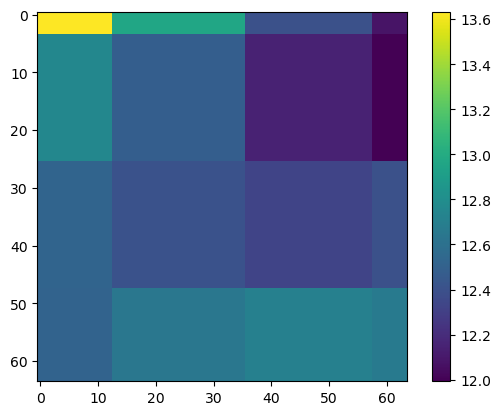

In [31]:
plt.imshow(train_data[0][1]-273)
plt.colorbar()

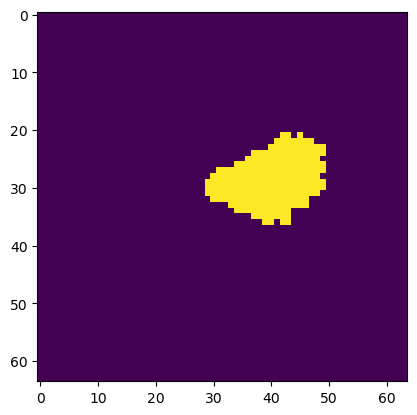

In [32]:
plt.imshow(np.array(labels)[0])

In [51]:
idx = 2088
poly_pairs[idx][0], poly_pairs[idx][1][['assessment_datetime', 'current_size']]

(YEAR                                                   2016.0
 NFIREID                                                1489.0
 BASRC                                                     3.0
 FIREMAPS                                                  2.0
 FIREMAPM                                                  3.0
 FIRECAUS                                                  4.0
 BURNCLAS                                                  4.0
 SDATE                                                    None
 EDATE                                                    None
 AFSDATE                                            2016-05-07
 AFEDATE                                                  None
 CAPDATE                                            2016-05-07
 POLY_HA                                              2.304009
 ADJ_HA                                               2.806096
 ADJ_FLAG                                                  2.0
 AGENCY                                                

In [418]:
np.sum(~np.isfinite(np.array(train_data).flatten()))

0

In [376]:
~np.isfinite(np.array(train_data).flatten())

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2996, 8) + inhomogeneous part.

In [385]:
for t in train_data:
    if t.shape[1] != 65:
        print(t.shape)

(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 64)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 64)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 64, 65)
(8, 

In [383]:
combined.shape

(8, 65, 64)

In [833]:
date_idx = np.argmax((modis_dc.time == modis_dc.sel(time=selected_fire.assessment_datetime, method='nearest').time).values)
era_lag = modis_dc.isel(time=slice(date_idx-32, date_idx+5))#sel(latitude = row_lat, longitude=row_lon, method='nearest')

In [ ]:
date_idx = np.argmax((modis_dc.time == modis_dc.sel(time=selected_fire.assessment_datetime, method='nearest').time).values)

In [848]:
lon = era_lag.sel(latitude = selected_fire.fire_location_latitude, longitude=selected_fire.fire_location_longitude, method='nearest').longitude
lat = era_lag.sel(latitude = selected_fire.fire_location_latitude, longitude=selected_fire.fire_location_longitude, method='nearest').latitude

lat_idx = np.where(era_lag.latitude == lat)[0][0]
lon_idx = np.where(era_lag.longitude == lon)[0][0]

In [95]:
from datacube.utils import geometry
import rasterio.features

def geometry_mask(geoms, geobox, all_touched=True, invert=True):
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms], out_shape=geobox.shape,transform=geobox.affine,all_touched=all_touched,invert=invert)



def set_mask(selected_geometry, shp_crs, shapeId, dataset):
    
    geom = geometry.Geometry(selected_geometry, crs=shp_crs)
    mask = geometry_mask([geom], dataset.geobox, invert=True)
    
    return dataset.where(mask)


In [864]:
masked = set_mask(burned_areas.iloc[2000].geometry, burned_areas.crs, None, croped_lag)

(56.75, 56.8)

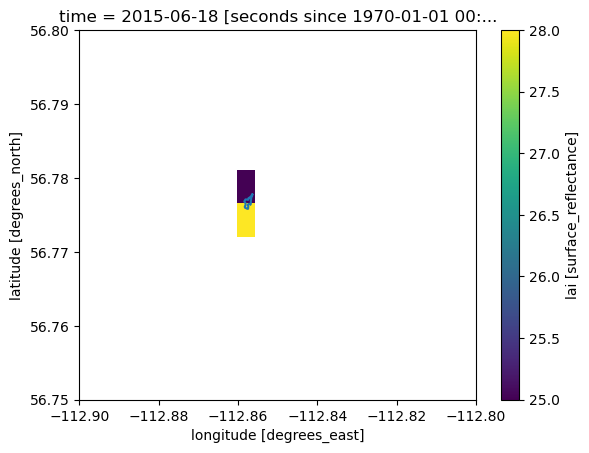

In [875]:
x,y = burned_areas.iloc[2000].geometry.exterior.xy
plt.plot(x,y)
masked.isel(time=30)['lai'].plot.imshow()
plt.xlim(-112.9, -112.8)
plt.ylim(56.75, 56.80)